# Fast Food Marketing Campaign 
### Context
In this exercise, we are data scientists working for a fast food chain that is planning to add a new item to it's menu. However, the fast food chain executives are still undecided between three possible marketing campaigns for the new item. In order to find the promotion that has the greatest effect on sales, the new item was introduced at locations in several randomly selected markets. For each location, a different promotion was used and the weekly sales of the new item were recorded for the first four weeks.

### Goal:
To identify the marketing campaign that results in the greatest sales of the new menu item.

### Target metric:
Weekly/4-week sales. It is directly proportional to the success of the marketing campaign.



### Introduction
We start by importing some neccessary modules

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, chisquare, ttest_ind

And we extract the csv file to pandas dataframe

In [92]:
df = pd.read_csv('WA_Marketing-Campaign.csv')
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


This is our main dataframe, let's see if wee need to do any data clean up

### The basics and data cleanup

In [93]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [94]:
df['MarketSize'].unique()

array(['Medium', 'Small', 'Large'], dtype=object)

We can see that we have 10 different markets of three different market sizes (Small, Medium, Large), where the new menu item was introduced. There are 137 locations, where the experiment was conducted. The age of a store is reported, however, we will not be using this metric at all. Let's see if there are any missing values now:

In [95]:
df.isna().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

There appears to be no missing values for any of the columns, which is great. Let's have a look at some summary statistics of the numerical columns:

In [96]:
df.describe().round(2)


,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.00,548.00,548.00,548.00,548.00,548.00
mean,5.72,479.66,8.50,2.03,2.50,53.47
std,2.88,287.97,6.64,0.81,1.12,16.76
min,1.00,1.00,1.00,1.00,1.00,17.34
25%,3.00,216.00,4.00,1.00,1.75,42.54
50%,6.00,504.00,7.00,2.00,2.50,50.20
75%,8.00,708.00,12.00,3.00,3.25,60.48
max,10.00,920.00,28.00,3.00,4.00,99.65


The values appear to be reasonable- there are no negative or very large numbers and values fall within the expected range. Let's take a closer look at our variable of interest (SalesInThousands) and see if the are any outliers we have to delete:

Text(0, 0.5, 'Sales In Thousands')

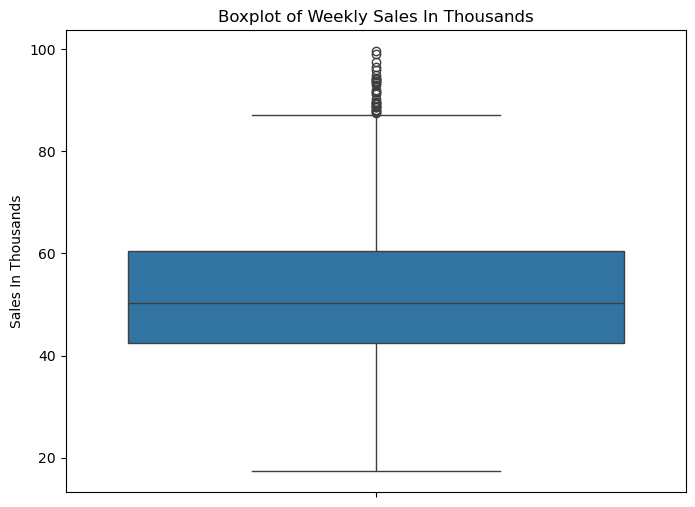

In [97]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='SalesInThousands', data=df)
plt.title('Boxplot of Weekly Sales In Thousands')
plt.ylabel('Sales In Thousands')

As we can see, there are quite a few data point above the upper whisker, which usually are considered outliers. However, since there are so many of them and the values are reasonable, we chose not to delete them. Let's proceed to data analysis now.

### Data Analysis
First, let's find the mean weekly sales for each promotion type, generate 95% confidence intervals (CI), find sample sizes (n) and variant proportions for each promotion type:

In [98]:
promo_1 = df[df['Promotion'] == 1]['SalesInThousands']
promo_2 = df[df['Promotion'] == 2]['SalesInThousands']
promo_3 = df[df['Promotion'] == 3]['SalesInThousands']

promos = [promo_1, promo_2, promo_3]

results = {
    'Promotion': [],
    'Mean weekly sales': [],
    r'95% CI': [],
    'n': [],
    'Variant proportion': []
}

total_count = sum([len(promo) for promo in promos])

for i, promo in enumerate(promos, start=1):
    mean_sales = promo.mean()
    n = len(promo)
    proportion = n / total_count
    se = stats.sem(promo)
    ci = stats.norm.interval(0.95, loc=mean_sales, scale=se)
    ci = (round(ci[0], 2), round(ci[1], 2))

    results['Promotion'].append(i)
    results['Mean weekly sales'].append(round(mean_sales, 2))
    results[r'95% CI'].append(ci)
    results['n'].append(n)
    results['Variant proportion'].append(round(proportion, 4))


results_df = pd.DataFrame(results)
results_df


,Promotion,Mean weekly sales,95% CI,n,Variant proportion
0,1,58.10,"(55.63, 60.57)",172,0.3139
1,2,47.33,"(45.17, 49.49)",188,0.3431
2,3,55.36,"(52.97, 57.76)",188,0.3431


We expect the variant proportion to be exactly a third (0.3333) for each promotion type, given correct experiment design and independent sampling. We will test whether observed variant proportion could arise by chance shortly, but first, let's have have a look at mean weekly sales in thousands for all three promotion types:

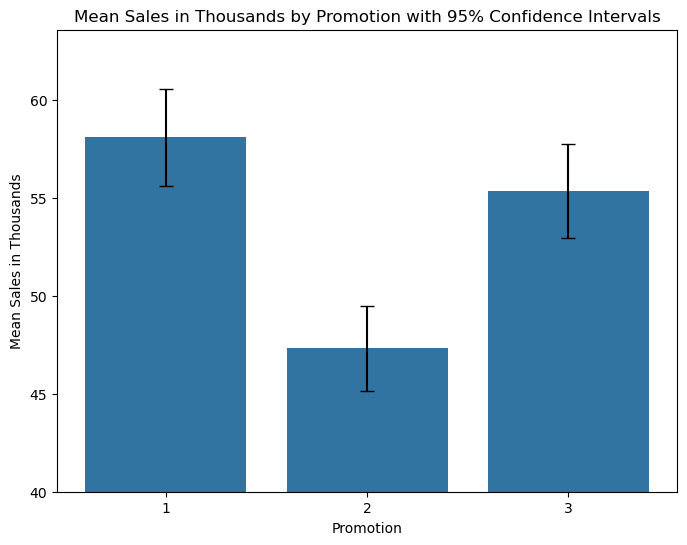

In [99]:
# Extracting lower and upper bounds for 95% CI
results_df['95% CI lower'] = results_df['95% CI'].apply(lambda x: x[0])
results_df['95% CI upper'] = results_df['95% CI'].apply(lambda x: x[1])

# Plot the barplot
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='Promotion', y='Mean weekly sales', data=results_df, capsize=0.1)

# Add error bars manually
for bar, lower, upper in zip(bars.patches, results_df['95% CI lower'], results_df['95% CI upper']):
    bar_height = bar.get_height()
    plt.errorbar(bar.get_x() + bar.get_width() / 2, bar_height, 
                 yerr=[[bar_height - lower], [upper - bar_height]], fmt='none', c='black', capsize=5)

plt.ylim(40, None)
plt.xlabel('Promotion')
plt.ylabel('Mean Sales in Thousands')
plt.title('Mean Sales in Thousands by Promotion with 95% Confidence Intervals')
plt.show()


We can observe that promotion 1 yields the highest mean weekly sales, followed by promotion 3 and then promotion 2. The difference in sales between promotion types 1 and 3 does not appear to be significant, while promotion 2 appears to much less effective than the former. Now, let's do a statistical test for sample ratio mismatch (SRM). SRM occurs when the observed ratio of samples in different groups of an experiment deviates significantly from the expected ratio. In our experiment, we have three groups (promotions 1, 2 and 3), so our expected sample ratio is 1/1/1 or 0.33/0.33/0.33. SRMs can signal underlying issues in the experimental setup, such as implementation errors, randomization failures, or unexpected user behavior. In our case, it can be indicitive of randomization failure, since the authors of the dataset explicitly stated that the assignment of promotion to a given location was random. We will use chi-squared test to test for SRM.

The chi-squared test is a statistical method used to determine if there is a significant association between categorical variables (promotions 1, 2 and 3). It compares the observed frequencies in each category to the frequencies we would expect if there were no association between the variables The test calculates a chi-squared statistic, which follows a chi-squared distribution, and uses it to assess the probability that any observed difference between the expected and observed frequencies is due to random chance. In the context of Sample Ratio Mismatch (SRM), the chi-squared test helps detect discrepancies between the expected and actual sample ratios in different groups of an experiment. 

Test parameters:<br>
let p = variant proportion <br>
α = 0.05 (acceptable type 1 error rate)<br>
$H_{0}$: $p_{promo1}$ = $p_{promo2}$ = $p_{promo3}$<br>
$H_{1}$: $p_{promo1}$ ≠ $p_{promo2}$ ≠ $p_{promo3}$<br>
if p-value < α then we reject the $H_{0}$

In [100]:
# Observed counts
observed_counts = results_df['n'].values

# Expected counts (assuming equal proportions)
total_counts = observed_counts.sum()
expected_counts = [total_counts / 3] * 3

# Chi-Square Test for SRM
chi2, p_value = chisquare(observed_counts, expected_counts)
print(f"Chi-square statistic: {chi2: .2f}, p-value: {p_value: .2f}")

Chi-square statistic:  0.93, p-value:  0.63


Since the p-value is more than α=0.05 (significance level), we fail to reject our null hypothesis. So, there is no evidence of SRM! This means that our subsequent statistical analyses should show results that are statistically substantiated! Now we will perform analysis of variance (ANOVA), to see if there are any statistically significant results between the three types of promotion. 

ANOVA, is a statistical technique used to compare the means of three or more groups to see if there is a significant difference among them. ANOVA helps in understanding whether the observed variances in sample data are due to genuine differences or merely random fluctuations. ANOVA is useful, because it can reduce the number of statistical tests that need to be done. If we were to use t-test, we would have to do three of them (promo1-2, promo1-3, promo2-3), which is more laborious and also increases the risk of type 1 error (false positive) as the errors compound with with each additional test.

Test parameters:<br>
let μ = mean weekly sales in thousands <br>
α = 0.05 (significance level)<br>
$H_{0}$: $μ_{promo1}$ = $μ_{promo2}$ = $μ_{promo3}$<br>
$H_{1}$: $μ_{promo1}$ ≠ $μ_{promo2}$ ≠ $μ_{promo3}$<br>
if p-value < α then we reject the $H_{0}$

In [101]:
# Performing ANOVA
f_statistic, p_value = f_oneway(promo_1, promo_2, promo_3)
print(f'The f-statistic: {f_statistic: .2f}, p-value {p_value: .2e}')

The f-statistic:  21.95, p-value  6.77e-10


Since p-value < α, we reject the null hypothesis. There are statistically significant difference between the promotion types in terms of mean weekly sales. Let's look deeper into this, and let's see which one specifically is better than the rest. Additionally, we are given market size, so let's also see if any of the three promotion types are better for a given market size. We will be grouping weekly data to monthy data, which will simplify things a little:

In [102]:
# Group by LocationID, sum the sales to give a monthly result
grouped_df = df.groupby('LocationID')['SalesInThousands'].sum().reset_index()

# Merge the new grouped_df with the old one, remove 'week' column
merged_df = df.drop(columns=['SalesInThousands']).drop_duplicates(subset=['LocationID']).merge(grouped_df, on='LocationID')
merged_df.drop(columns=['week'], inplace=True)
merged_df

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,SalesInThousands
0,1,Medium,1,4,3,137.68
1,1,Medium,2,5,2,118.18
2,1,Medium,3,12,1,162.72
3,1,Medium,4,1,2,134.83
4,1,Medium,5,10,2,116.01
...,...,...,...,...,...,...
132,10,Large,916,7,2,191.04
133,10,Large,917,14,3,211.87
134,10,Large,918,6,1,223.90
135,10,Large,919,2,1,244.40


We will again compute MeanMonthlySales,	95% CI,	n,	Variant proportion for a given MarketSize and Promotion type:

In [109]:
results = {
    'MarketSize': [],
    'Promotion': [],
    'MeanMonthlySales': [],
    r'95% CI': [],
    'n': [],
    'Variant proportion': []
}

# Get total number of entries per market size
market_sizes = df['MarketSize'].unique()
total_per_size = df['MarketSize'].value_counts()

for market_size in market_sizes:
    for promotion in df['Promotion'].unique():
        # Filter data for the current market size and promotion
        subset = df[(df['MarketSize'] == market_size) & (df['Promotion'] == promotion)]
        
        # Calculate mean monthly sales
        mean_sales = subset['SalesInThousands'].mean()
        
        # Calculate 95% confidence interval
        ci = stats.t.interval(0.95, len(subset)-1, loc=mean_sales, scale=stats.sem(subset['SalesInThousands']))
        ci = (round(ci[0], 2), round(ci[1], 2))
        
        # Number of entries
        n = len(subset)
        
        # Variant proportion
        variant_proportion = n / total_per_size[market_size]
        
        # Append results to the dictionary
        results['MarketSize'].append(market_size)
        results['Promotion'].append(promotion)
        results['MeanMonthlySales'].append(mean_sales)
        results['95% CI'].append(ci)
        results['n'].append(n)
        results['Variant proportion'].append(variant_proportion)

# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results)
results_df.round(2)


,MarketSize,Promotion,MeanMonthlySales,95% CI,n,Variant proportion
0,Medium,3,45.47,"(43.98, 46.96)",116,0.36
1,Medium,2,39.11,"(37.43, 40.79)",108,0.34
2,Medium,1,47.67,"(46.04, 49.31)",96,0.30
3,Small,3,59.51,"(57.31, 61.72)",24,0.40
4,Small,2,50.81,"(47.68, 53.94)",16,0.27
5,Small,1,60.16,"(57.76, 62.56)",20,0.33
6,Large,3,77.20,"(73.02, 81.39)",48,0.29
7,Large,2,60.32,"(56.39, 64.25)",64,0.38
8,Large,1,75.24,"(71.09, 79.39)",56,0.33


And now again we will test for SRM for the three subsets of data:

In [110]:
# Function to perform chi-squared test for SRM
def chi_squared_srm(market_size):
    # Filter data for the given market size
    subset = results_df[results_df['MarketSize'] == market_size]
    
    # Observed counts
    observed = subset['n'].values
    
    # Expected counts (using overall proportions)
    total_n = results_df['n'].sum()
    total_promo = results_df.groupby('Promotion')['n'].sum()
    expected = [total_promo[promo] * sum(observed) / total_n for promo in subset['Promotion']]
    
    # Perform chi-squared test
    chi2_stat, p_val = stats.chisquare(f_obs=observed, f_exp=expected)
    
    return chi2_stat, p_val

# Perform chi-squared tests for each market size
for market_size in results_df['MarketSize'].unique():
    chi2_stat, p_val = chi_squared_srm(market_size)
    print(f'Chi-squared test for {market_size} market size:')
    print(f'Chi-squared statistic: {chi2_stat: .2f}, p-value: {p_val: .2f}\n')


Chi-squared test for Medium market size:
Chi-squared statistic:  0.58, p-value:  0.75

Chi-squared test for Small market size:
Chi-squared statistic:  1.66, p-value:  0.44

Chi-squared test for Large market size:
Chi-squared statistic:  2.52, p-value:  0.28



There appears to be no evidence to suggest the presence of SRM, so we carry on as usual:

Now let's repeat the ANOVA test, but for three market sizes to see if there are differences between promotions for a given market size:

In [113]:
market_sizes = ['Small', 'Medium', 'Large']

# Initialize lists to store the results
results = {
    'MarketSize': [],
    'Promo1Mean': [],
    'Promo2Mean': [],
    'Promo3Mean': [],
    'FStatistic': [],
    'PValue': []
}

for size in market_sizes:
    promo_1 = merged_df[(merged_df['Promotion'] == 1) & (merged_df['MarketSize'] == size)]['SalesInThousands']
    promo_2 = merged_df[(merged_df['Promotion'] == 2) & (merged_df['MarketSize'] == size)]['SalesInThousands']
    promo_3 = merged_df[(merged_df['Promotion'] == 3) & (merged_df['MarketSize'] == size)]['SalesInThousands']
    
    means = promo_1.mean(), promo_2.mean(), promo_3.mean()

    # Performing ANOVA
    f_statistic, p_value = f_oneway(promo_1, promo_2, promo_3)
    
    # Append the results
    results['MarketSize'].append(size)
    results['Promo1Mean'].append(means[0])
    results['Promo2Mean'].append(means[1])
    results['Promo3Mean'].append(means[2])
    results['FStatistic'].append(f_statistic)
    results['PValue'].append(p_value)

results_df = pd.DataFrame(results)

results_df['Promo1Mean'] = results_df['Promo1Mean'].round(2)
results_df['Promo2Mean'] = results_df['Promo2Mean'].round(2)
results_df['Promo3Mean'] = results_df['Promo3Mean'].round(2)
results_df['FStatistic'] = results_df['FStatistic'].round(2)
results_df['PValue'] = results_df['PValue'].round(4)

results_df

,MarketSize,Promo1Mean,Promo2Mean,Promo3Mean,FStatistic,PValue
0,Small,240.65,203.24,238.06,9.64,0.0032
1,Medium,190.69,156.46,181.88,10.35,0.0001
2,Large,300.94,241.29,308.82,5.52,0.0077


We can see again that p-value for small, medium and large market sizes fall under α of 0.05, so we can say that there are statistically significant differences between promotions for a given market size as well. From the above table, we can see that promotions 1, 3 are much better than promotion 2 for all market sizes, but to actually understand if the difference is statistically significant, we have to do t-tests for all the pairs:

In [117]:
market_sizes = ['Small', 'Medium', 'Large']
alpha = 0.05 # Significance level

# Initialize lists to store the results
results = {
    'MarketSize': [],
    'PromoPair': [],
    '1stPromoMean': [],
    '2ndPromoMean': [],
    't-statistic': [],
    'PValue': [],
    'RejectNull': []
}

for size in market_sizes:
    for promo_pair, promo_data in [((1, 2), (promo_1, promo_2)), ((1, 3), (promo_1, promo_3)), ((2, 3), (promo_2, promo_3))]:
        means = promo_data[0].mean(), promo_data[1].mean()

        # Performing t-test
        statistic, pvalue = ttest_ind(promo_data[0], promo_data[1])

        # Append the results
        results['MarketSize'].append(size)
        results['PromoPair'].append(f"{promo_pair[0]} & {promo_pair[1]}")
        results['1stPromoMean'].append(means[0])
        results['2ndPromoMean'].append(means[1])
        results['t-statistic'].append(statistic)
        results['PValue'].append(pvalue)
        results['RejectNull'].append(pvalue < alpha)


results_df = pd.DataFrame(results)

results_df['1stPromoMean'] = results_df['1stPromoMean'].round(2)
results_df['2ndPromoMean'] = results_df['2ndPromoMean'].round(2)
results_df['t-statistic'] = results_df['t-statistic'].round(2)
results_df['PValue'] = results_df['PValue'].round(4)

results_df


,MarketSize,PromoPair,1stPromoMean,2ndPromoMean,t-statistic,PValue,RejectNull
0,Small,1 & 2,300.94,241.29,2.65,0.0132,True
1,Small,1 & 3,300.94,308.82,-0.34,0.7370,False
2,Small,2 & 3,241.29,308.82,-2.95,0.0067,True
3,Medium,1 & 2,300.94,241.29,2.65,0.0132,True
4,Medium,1 & 3,300.94,308.82,-0.34,0.7370,False
5,Medium,2 & 3,241.29,308.82,-2.95,0.0067,True
6,Large,1 & 2,300.94,241.29,2.65,0.0132,True
7,Large,1 & 3,300.94,308.82,-0.34,0.7370,False
8,Large,2 & 3,241.29,308.82,-2.95,0.0067,True


As we can see from the table above, promotions 1 and 3 outperform promotion 2 for small, medium and large market sizes. The difference between 1 and 3 for all market sizes is not statistically significant, so it appears that the promotions are 1 and 3 are equally superior to promotion 2. But what about change over four weeks? Since we looked at overall 28 day sales, we might have missed some more coarse details, maybe promotion 1 is better initially and then promotion 3 outperforms 1 latter in the month. To check whether this is the case, we will do some line plotting:

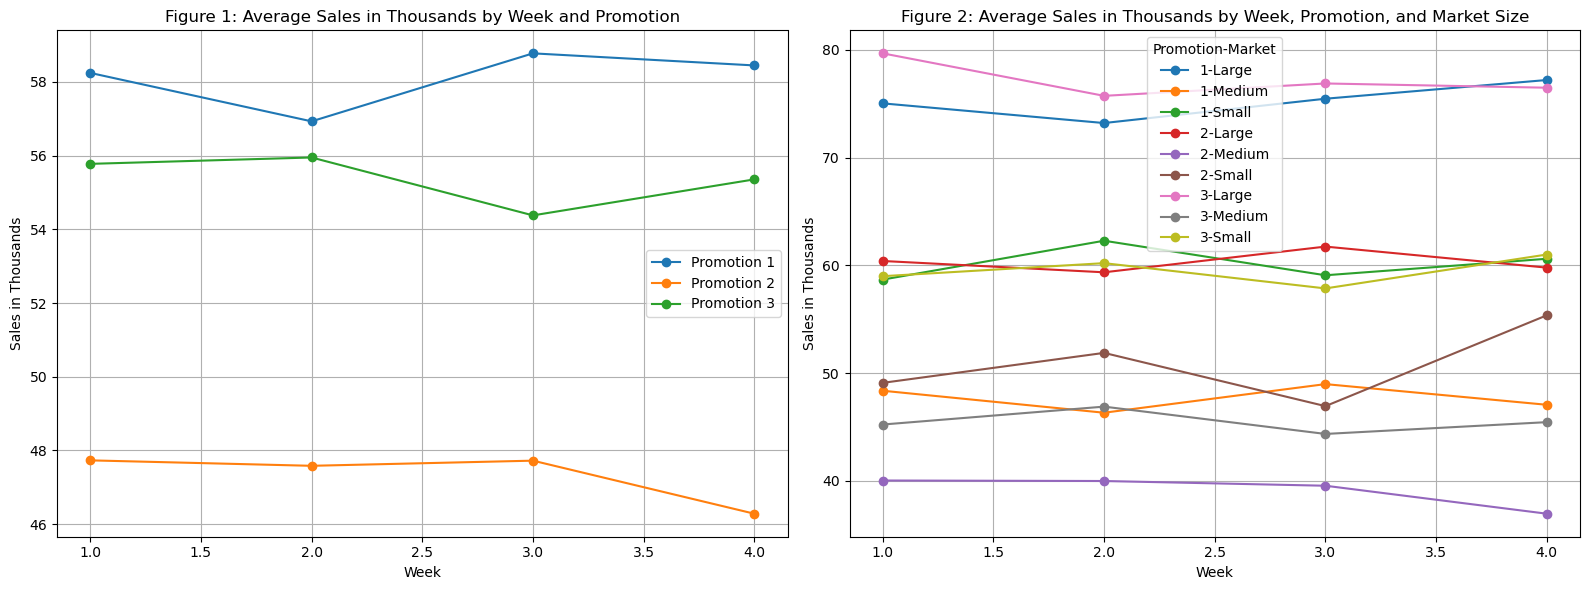

In [107]:
# Group by week and promotion, then calculate the mean of SalesInThousands
grouped_df1 = df.groupby(['week', 'Promotion'])['SalesInThousands'].mean().reset_index()

# Pivot the DataFrame to get weeks as rows and promotions as columns
pivot_df1 = grouped_df1.pivot(index='week', columns='Promotion', values='SalesInThousands')

# Group by week, promotion, and market size, then calculate the mean of SalesInThousands
grouped_df2 = df.groupby(['week', 'Promotion', 'MarketSize'])['SalesInThousands'].mean().reset_index()

# Create a unique identifier for each combination of promotion and market size
grouped_df2['Promo_Market'] = grouped_df2['Promotion'].astype(str) + '-' + grouped_df2['MarketSize']

# Pivot the DataFrame to get weeks as rows and Promo_Market as columns
pivot_df2 = grouped_df2.pivot(index='week', columns='Promo_Market', values='SalesInThousands')

# Create the dashboard with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first chart (Promotion vs. Average Sales)
for promotion in pivot_df1.columns:
    ax1.plot(pivot_df1.index, pivot_df1[promotion], marker='o', label=f'Promotion {promotion}')

ax1.set_xlabel('Week')
ax1.set_ylabel('Sales in Thousands')
ax1.set_title('Figure 1: Average Sales in Thousands by Week and Promotion')
ax1.legend()
ax1.grid(True)

# Plot the second chart (Promotion-Market vs. Average Sales)
for promo_market in pivot_df2.columns:
    ax2.plot(pivot_df2.index, pivot_df2[promo_market], marker='o', label=promo_market)

ax2.set_xlabel('Week')
ax2.set_ylabel('Sales in Thousands')
ax2.set_title('Figure 2: Average Sales in Thousands by Week, Promotion, and Market Size')
ax2.legend(title='Promotion-Market')
ax2.grid(True)

# Display the dashboard
plt.tight_layout()
plt.show()


In the figure 1, we can see that for all three promotions the variation in sales between the weeks is minimal. The difference between min and max sales is less than 2k, and it does not seem that there are any up or downward trends for any of the promotions by visual inspection. In figure 2, we can observe a similar stability across weeks trend for all but one Promotion-MarketSize pair (2-small), where from week 3 to 4 we can see a steep increase in sales in the magnitute of around 7k. But since the promotion 2 was should be inferior, we will not look further into this.

### Conclusion
Overall, we can definitelly see that average weekly sales for a promotion-marketSize pair does not change, so the sales are not time-dependent, but are only promotion dependents, where 1,3 are equally good and promotion 2 is measurably inferior to the former. So, in general, as consultants we suggest the cheaper option between 1 and 3 promotion type to be implemented in other locations and for all market sizes.